### Initial Setup

In [81]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [83]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [84]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [85]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

GPU already assigned before: 0


### Load and Visualize Dataset

In [86]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [87]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [88]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [89]:
# Open zip of dataset
open_zip('trussData.zip')

In [90]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

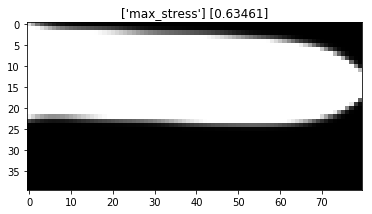

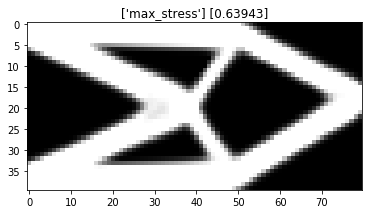

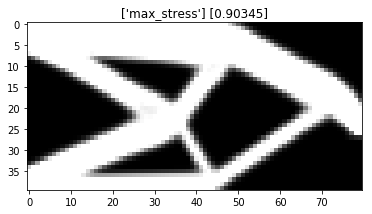

In [91]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [92]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
    
    return np.mean(distances)

In [93]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [94]:
# VAE without Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        return x, mu, logvar

In [95]:
# Loss function for this task, combines reconstruction and KL for the image task
def loss_function(reconstruction, image, mu, logvar, attributes, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    return reconstruction_loss, kl_loss

In [96]:
# VAE conv kernel size = 7 z_dim=2
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE(kernel_size=5, z_dim=2)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
val_recon_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar = model(image)
        reconstruction_loss, kl_loss = loss_function(recon, image, mu, logvar, attribute, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    
    # Get training data accuracy
    train_recon_score = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    train_recon_scores.append(train_recon_score)
    
    # Get validation data accuracy
    val_recon_score = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    val_recon_scores.append(val_recon_score)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.6874038432325635
Reconstruction Loss: 0.6871936976909637
KL Loss: 0.00021014512505124523
Trainig Reconstruction Score: 44.30928
Validation Reconstruction Score: 44.483887

Epoch: 1
Total Loss: 0.6512689547879356
Reconstruction Loss: 0.6505446510655539
KL Loss: 0.0007243017898872495
Trainig Reconstruction Score: 43.5685
Validation Reconstruction Score: 43.80905

Epoch: 2
Total Loss: 0.6254067753042494
Reconstruction Loss: 0.6246652458395276
KL Loss: 0.0007415313714383437
Trainig Reconstruction Score: 42.2262
Validation Reconstruction Score: 42.395523

Epoch: 3
Total Loss: 0.6016040699822562
Reconstruction Loss: 0.600772932597569
KL Loss: 0.0008311365756006646
Trainig Reconstruction Score: 41.076927
Validation Reconstruction Score: 41.168076

Epoch: 4
Total Loss: 0.5731641020093645
Reconstruction Loss: 0.5722671908991678
KL Loss: 0.000896910109856565
Trainig Reconstruction Score: 38.802044
Validation Reconstruction Score: 38.801556

Epoch: 5
Tot

Trainig Reconstruction Score: 34.68868
Validation Reconstruction Score: 35.07768

Epoch: 42
Total Loss: 0.44350531739848
Reconstruction Loss: 0.44222417856965746
KL Loss: 0.0012811389768363109
Trainig Reconstruction Score: 34.608025
Validation Reconstruction Score: 35.01793
New Best Model Saved!

Epoch: 43
Total Loss: 0.44469020579542434
Reconstruction Loss: 0.44340848241533554
KL Loss: 0.0012817244868659015
Trainig Reconstruction Score: 34.62642
Validation Reconstruction Score: 35.072243

Epoch: 44
Total Loss: 0.44388743000371117
Reconstruction Loss: 0.4425751234803881
KL Loss: 0.001312306519996907
Trainig Reconstruction Score: 34.640797
Validation Reconstruction Score: 35.104218

Epoch: 45
Total Loss: 0.43999471834727694
Reconstruction Loss: 0.438676763858114
KL Loss: 0.0013179554288009448
Trainig Reconstruction Score: 34.651775
Validation Reconstruction Score: 35.06948

Epoch: 46
Total Loss: 0.4398374225412096
Reconstruction Loss: 0.4385549409048898
KL Loss: 0.0012824831846436219
Tr

Total Loss: 0.4335700422525406
Reconstruction Loss: 0.43228062476430623
KL Loss: 0.0012894185542661164
Trainig Reconstruction Score: 34.399647
Validation Reconstruction Score: 34.82274

Epoch: 83
Total Loss: 0.43042204592909133
Reconstruction Loss: 0.4291189159665789
KL Loss: 0.0013031282079672174
Trainig Reconstruction Score: 34.193745
Validation Reconstruction Score: 34.725086

Epoch: 84
Total Loss: 0.4303957555975233
Reconstruction Loss: 0.429118903194155
KL Loss: 0.0012768527725711466
Trainig Reconstruction Score: 34.1981
Validation Reconstruction Score: 34.61905
New Best Model Saved!

Epoch: 85
Total Loss: 0.4296008684805461
Reconstruction Loss: 0.42832258599145073
KL Loss: 0.0012782828649505972
Trainig Reconstruction Score: 34.137478
Validation Reconstruction Score: 34.58705
New Best Model Saved!

Epoch: 86
Total Loss: 0.43017867250101904
Reconstruction Loss: 0.42889629985604966
KL Loss: 0.001282374612388334
Trainig Reconstruction Score: 34.09845
Validation Reconstruction Score: 

Trainig Reconstruction Score: 33.907616
Validation Reconstruction Score: 34.52155

Epoch: 124
Total Loss: 0.42343897606645314
Reconstruction Loss: 0.42214467355183194
KL Loss: 0.0012943005970945316
Trainig Reconstruction Score: 33.955875
Validation Reconstruction Score: 34.533295

Epoch: 125
Total Loss: 0.42482091060706545
Reconstruction Loss: 0.4235373096806662
KL Loss: 0.0012836009014530905
Trainig Reconstruction Score: 34.109566
Validation Reconstruction Score: 34.593014

Epoch: 126
Total Loss: 0.42502686168466297
Reconstruction Loss: 0.42374437025615147
KL Loss: 0.0012824936270979899
Trainig Reconstruction Score: 34.014816
Validation Reconstruction Score: 34.63816

Epoch: 127
Total Loss: 0.42352935884680065
Reconstruction Loss: 0.4222595512866974
KL Loss: 0.00126980844319665
Trainig Reconstruction Score: 33.935173
Validation Reconstruction Score: 34.52022

Epoch: 128
Total Loss: 0.4247407696076802
Reconstruction Loss: 0.4234669097832271
KL Loss: 0.0012738604148450708
Trainig Recons

Trainig Reconstruction Score: 33.64325
Validation Reconstruction Score: 34.341698

Epoch: 165
Total Loss: 0.4163514128753117
Reconstruction Loss: 0.4150919122355325
KL Loss: 0.0012594994007875877
Trainig Reconstruction Score: 33.64573
Validation Reconstruction Score: 34.344383

Epoch: 166
Total Loss: 0.41624794006347654
Reconstruction Loss: 0.4149905502796173
KL Loss: 0.0012573894321186733
Trainig Reconstruction Score: 33.63831
Validation Reconstruction Score: 34.33312

Epoch: 167
Total Loss: 0.4164642725672041
Reconstruction Loss: 0.41520416608878546
KL Loss: 0.0012601079502409058
Trainig Reconstruction Score: 33.643784
Validation Reconstruction Score: 34.349586

Epoch: 168
Total Loss: 0.4161712131329945
Reconstruction Loss: 0.414911482163838
KL Loss: 0.0012597309425473214
Trainig Reconstruction Score: 33.632298
Validation Reconstruction Score: 34.322865

Epoch: 169
Total Loss: 0.4160821752888816
Reconstruction Loss: 0.4148237773350307
KL Loss: 0.0012583981733769178
Trainig Reconstruc

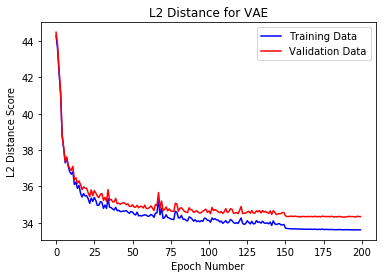

In [97]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.show()

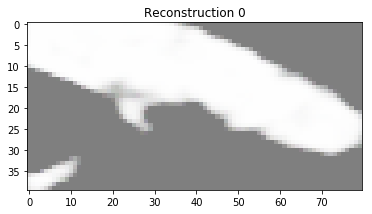

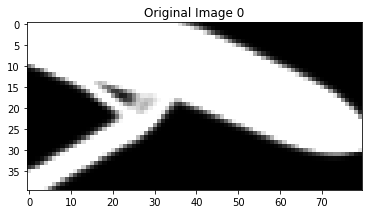

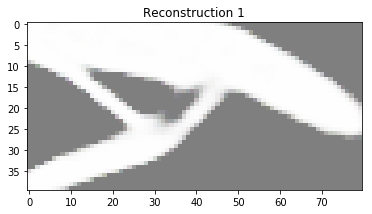

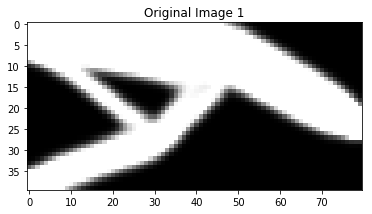

In [99]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            if len(model_output) == 2:
                return model_output, ground_truth
            
model_out, gt = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [100]:
test_recon_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))

Test L2 Score: 34.388287


In [101]:
# Gets the twod representation of teh data
def get_2D_representation(model, data_loader):
    model.eval()
    all_frame = pd.DataFrame()
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            two_d = model.representation(image)
            two_d = two_d.cpu().numpy()
            frame = pd.DataFrame(data=two_d, columns=['x', 'y'])
            frame['max_stress'] = attribute.cpu().numpy()[0] 
            all_frame = all_frame.append(frame)
    return all_frame
            

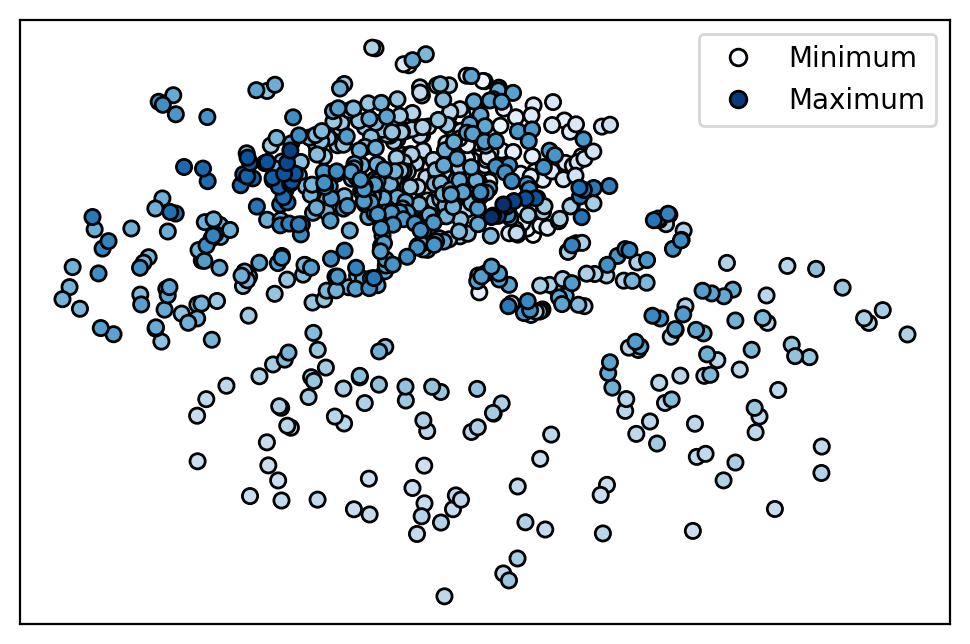

In [104]:
from matplotlib import cm
from matplotlib.lines import Line2D

frame = get_2D_representation(best_model, train_loader_score)
frame = frame.sort_values('max_stress')
minimum = frame.max_stress.min()
maximum = frame.max_stress.max()
fig, ax = plt.subplots(dpi=200)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
blue_cmap = cm.get_cmap('Blues')

plt.scatter(frame.x, frame.y, c=frame.max_stress, s=30, cmap=blue_cmap, edgecolors='k')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Minimum', markeredgewidth=1, markeredgecolor='k', markerfacecolor=blue_cmap(0), markersize=6),
                   Line2D([0], [0], marker='o', color='w', label='Maximum', markeredgewidth=1, markeredgecolor='k', markerfacecolor=blue_cmap(maximum), markersize=6)]
plt.legend(handles=legend_elements)

plt.savefig('twodrep_noregression.png')
plt.show()